# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Project
# Alzheimer’s Disease and Cognitive Impairment Prediction



---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):E109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display

from sklearn import linear_model
import copy
from sklearn import preprocessing
import sklearn.discriminant_analysis as da
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import seaborn as sns
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)



## Multiclass Alzheimer’s Disease and Cognitive Impairment Classification

In this problem, you will build a model for diagnosing disorders in a patient's cognitive impairment. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *cognitive normal* (class 0)
- having *dementia* (class 1)
- or having *MCI* (class 2). 

The data set is provided in the file `adnimerge.csv`. 

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the ADNI.



In [2]:
np.random.seed(9001)

#note: data is already sorted before loading
df = pd.read_csv('data/ADNIMERGE.csv')
print(df.shape)
print(df[0:2])


(13017, 94)
   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER      ...       EcogSPDivatt_bl EcogSPTotal_bl   FDG_bl PIB_bl  \
0     Male      ...                   NaN            NaN  1.36926    NaN   
1     Male      ...                   NaN            NaN  1.36926    NaN   

   AV45_bl  Years_bl  Month_bl  Month  M  update_stamp  
0      NaN  0.000000   0.00000      0  0       50:48.0  
1      NaN  0.490075   5.86885      6  6       50:48.0  

[2 rows x 94 columns]


## 1.1 generate DX_last and DX_change, DX_last is the most recent available diagnosis of a patient.  If a patient diagnosis category changes over time, then DX_change is 1, otherwise 0. Entries with DX_change positive are removed from the dataset.


In [4]:
#this is a test just for on RID
#datapre-precessing
x_dist=df.RID.unique()
#x_dist[0:10]
temp_df=df.loc[(df['RID']==2)]

temp_df_fill=copy.copy(temp_df)
temp_df_fill['DX']=temp_df['DX'].fillna(method='bfill')

temp_df_fill.to_csv('data/temp_df_fill_bf.csv')
temp_df_fill['DX']=temp_df_fill['DX'].fillna(method='ffill')

temp_df_fill.to_csv('data/temp_df_fill_ff.csv')
temp_df_fill['DX_last']=copy.copy(temp_df_fill.DX)

#add a new field DX_change, if there is a categorical change for one participant, then it will be 1, this will be used
# to move data

temp_df_fill['DX_change']=0
col_last=temp_df_fill.shape[1]


tmp_value=temp_df_fill.iloc[temp_df_fill.shape[0]-1,temp_df_fill.shape[1]-2]
    
for i in range(0,temp_df_fill.shape[0]-1):
    #print(temp_df_fill.iloc[i,col_last-2],tmp_value)
    if (temp_df_fill.iloc[i,col_last-2]!=tmp_value):
         temp_df_fill['DX_change']=1
   
    temp_df_fill.iloc[i,col_last-2]=tmp_value

    
temp_df_fill.to_csv('data/temp_df_fill_ff_DX_last.csv')
print(temp_df_fill[0:2])
#print(temp_df_fill.DX_recent[0:10])

   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER    ...       FDG_bl PIB_bl AV45_bl  Years_bl  Month_bl  Month  M  \
0     Male    ...      1.36926    NaN     NaN  0.000000   0.00000      0  0   
1     Male    ...      1.36926    NaN     NaN  0.490075   5.86885      6  6   

   update_stamp  DX_last  DX_change  
0       50:48.0       CN          1  
1       50:48.0       CN          1  

[2 rows x 96 columns]


In [5]:
#create DX_last, DX_change, backfill/forward fill to get DX_last, and BILAVAMT, BILAVVOL, 
x_dist=df.RID.unique()
#x_dist[0:10]
df_fill=pd.DataFrame()
count=1
for i in x_dist:
    temp_df=pd.DataFrame()
    temp_df_fill=pd.DataFrame()
    
    temp_df=df.loc[(df['RID']==i)]
 
    temp_df_fill=copy.copy(temp_df)
    temp_df_fill['DX']=temp_df['DX'].fillna(method='bfill')
 
    temp_df_fill['DX']=temp_df['DX'].fillna(method='ffill')
  

    temp_df_fill['DX_last']=copy.copy(temp_df_fill.DX)
    temp_df_fill['DX_change']=0
  
    if(temp_df_fill.shape[0]>1):
        col_last=df_fill.shape[1]
        tmp_value=temp_df_fill.iloc[temp_df_fill.shape[0]-1,temp_df_fill.shape[1]-2]

        for i in range(0,temp_df_fill.shape[0]-1):
            if (temp_df_fill.iloc[i,col_last-2]!=tmp_value):
                 temp_df_fill['DX_change']=1
            temp_df_fill.iloc[i,col_last-2]=tmp_value

    if (count==1):
        df_fill=temp_df_fill
    else:
        df_fill=pd.concat([df_fill, temp_df_fill], axis=0)
    count=count+1
    
    
temp_df_fill.to_csv('data/temp_df_fill_ff_DX_last.csv')


df_fill.to_csv('data/df_fill_DX_change.csv')

print(df_fill[0:2])

   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER    ...       FDG_bl PIB_bl AV45_bl  Years_bl  Month_bl  Month  M  \
0     Male    ...      1.36926    NaN     NaN  0.000000   0.00000      0  0   
1     Male    ...      1.36926    NaN     NaN  0.490075   5.86885      6  6   

   update_stamp  DX_last  DX_change  
0       50:48.0       CN          1  
1       50:48.0       CN          1  

[2 rows x 96 columns]


In [6]:
print(df_fill.columns)

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl

In [7]:
#drop columns that doesnt have relevent or enough data
column_drop_clean=['PIB', 'AV45','MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal','EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl',
       'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl',
       'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl',
       'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl',
       'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl',
       'PIB_bl', 'AV45_bl', 'Years_bl', 'Month_bl', 'Month', 'M',
       'update_stamp']

df_fill_test=df_fill.drop(column_drop_clean, axis=1)
df_fill_test.to_csv('data/df_fill_drop_bio.csv')

print(df_fill_test.shape)

(13017, 37)


In [8]:

df_fill_drop=copy.copy(df_fill_test)
df_fill_drop=df_fill_drop.dropna()
#also drop those that with DX_change=1
df_fill_drop=df_fill_drop.loc[(df_fill_drop['DX_change']==0)]
df_fill_drop.to_csv('data/df_fill_drop_DX_change_bio.csv')
print(df_fill_drop.shape)

(1383, 37)


In [9]:
#drop some columns

#df_fill_drop_clean=df_fill_drop.drop('Unnamed: 0', axis=1)
df_fill_drop_clean=df_fill_drop.drop('PTID', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('VISCODE', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('SITE', axis=1)
#COLPROT will be dropped once all the data preprocess is done
#df_fill_drop_clean=df_fill_drop_clean.drop('COLPROT', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('ORIGPROT', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('EXAMDATE', axis=1)

#from biomark file
#df_fill_drop_clean=df_fill_drop_clean.drop('Phase', axis=1)


print(df_fill_drop_clean[0:2])


    RID COLPROT DX_bl   AGE PTGENDER  PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male        18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male        18  Not Hisp/Latino    White   

    PTMARRY  APOE4    ...      Ventricles  Hippocampus  WholeBrain  \
14  Married    1.0    ...         84599.0       5319.0   1129830.0   
15  Married    1.0    ...         88580.0       5446.0   1100060.0   

    Entorhinal  Fusiform  MidTemp        ICV        DX   DX_last  DX_change  
14      1791.0   15506.0  18422.0  1920690.0  Dementia  Dementia          0  
15      2427.0   14400.0  16972.0  1906430.0  Dementia  Dementia          0  

[2 rows x 32 columns]


In [10]:
print(df_fill_drop_clean.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last', 'DX_change'],
      dtype='object')


In [11]:
#adding dummy variables
categorical_columns_drop = ['DX_bl', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT','PTMARRY','FLDSTRENG',
                            'FSVERSION','DX','DX_last','DX_change']
#categorical_columns = ['DX_bl_cat', 'PTGENDER_cat', 'PTEDUCAT_cat', 'PTETHCAT_cat', 'PTRACCAT_cat','PTMARRY_cat'
#                       ,'FLDSTRENG_cat','FSVERSION_cat']
categorical_columns = ['PTGENDER_cat', 'PTEDUCAT_cat', 'PTETHCAT_cat', 'PTRACCAT_cat','PTMARRY_cat'
                       ,'FLDSTRENG_cat','FSVERSION_cat']

#categorical_columns_g2cols = ['season', 'month', 'day_of_week', 'weather']
numerical_columns = ['AGE', 'APOE4', 'FDG', 'CDRSB','ADAS11','ADAS13','MMSE',
                     'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ',
                     'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV']

In [12]:
#df_fill_drop_clean["DX_bl"] = df_fill_drop_clean["DX_bl"].astype('category')
#df_fill_drop_clean["DX_bl_cat"] = df_fill_drop_clean["DX_bl"].cat.codes

df_fill_drop_clean["PTGENDER"] = df_fill_drop_clean["PTGENDER"].astype('category')
df_fill_drop_clean["PTGENDER_cat"] = df_fill_drop_clean["PTGENDER"].cat.codes

df_fill_drop_clean["PTEDUCAT"] = df_fill_drop_clean["PTEDUCAT"].astype('category')
df_fill_drop_clean["PTEDUCAT_cat"] = df_fill_drop_clean["PTEDUCAT"].cat.codes

df_fill_drop_clean["PTETHCAT"] = df_fill_drop_clean["PTETHCAT"].astype('category')
df_fill_drop_clean["PTETHCAT_cat"] = df_fill_drop_clean["PTETHCAT"].cat.codes

df_fill_drop_clean["PTRACCAT"] = df_fill_drop_clean["PTRACCAT"].astype('category')
df_fill_drop_clean["PTRACCAT_cat"] = df_fill_drop_clean["PTRACCAT"].cat.codes

df_fill_drop_clean["PTMARRY"] = df_fill_drop_clean["PTMARRY"].astype('category')
df_fill_drop_clean["PTMARRY_cat"] = df_fill_drop_clean["PTMARRY"].cat.codes

df_fill_drop_clean["FLDSTRENG"] = df_fill_drop_clean["FLDSTRENG"].astype('category')
df_fill_drop_clean["FLDSTRENG_cat"] = df_fill_drop_clean["FLDSTRENG"].cat.codes


df_fill_drop_clean["FSVERSION"] = df_fill_drop_clean["FSVERSION"].astype('category')
df_fill_drop_clean["FSVERSION_cat"] = df_fill_drop_clean["FSVERSION"].cat.codes

df_fill_drop_clean["DX_last"] = df_fill_drop_clean["DX_last"].astype('category')
df_fill_drop_clean["DX_last_cat"] = df_fill_drop_clean["DX_last"].cat.codes

print(df_fill_drop_clean[0:2])

    RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4     ...        DX_last  DX_change  PTGENDER_cat  \
14  Married    1.0     ...       Dementia          0             1   
15  Married    1.0     ...       Dementia          0             1   

    PTEDUCAT_cat  PTETHCAT_cat  PTRACCAT_cat  PTMARRY_cat  FLDSTRENG_cat  \
14            12             1             6            1              0   
15            12             1             6            1              0   

    FSVERSION_cat  DX_last_cat  
14              1            1  
15              1            1  

[2 rows x 40 columns]


In [13]:
df_fill_drop_clean.to_csv('data/df_fill_drop_clean.csv')

In [14]:
df_fill_drop_clean.dtypes

RID                         int64
COLPROT                    object
DX_bl                      object
AGE                       float64
PTGENDER                 category
PTEDUCAT                 category
PTETHCAT                 category
PTRACCAT                 category
PTMARRY                  category
APOE4                     float64
FDG                       float64
CDRSB                     float64
ADAS11                    float64
ADAS13                    float64
MMSE                      float64
RAVLT_immediate           float64
RAVLT_learning            float64
RAVLT_forgetting          float64
RAVLT_perc_forgetting     float64
FAQ                       float64
FLDSTRENG                category
FSVERSION                category
Ventricles                float64
Hippocampus               float64
WholeBrain                float64
Entorhinal                float64
Fusiform                  float64
MidTemp                   float64
ICV                       float64
DX            

## 1.2: adding dummy variables

In [15]:
#df_fill_drop_clean["DX_bl_cat"] = df_fill_drop_clean["DX_bl_cat"].astype('int64')

df_fill_drop_clean_dummy = pd.get_dummies(df_fill_drop_clean, columns=categorical_columns, drop_first=True)
#df_fill_drop_clean_dumm=df_fill_drop_clean_dummy.drop(categorical_columns_drop,axis=1)
#df_fill_drop_clean_dumm=df_fill_drop_clean_dummy.drop('PTMARRY_cat_2',axis=1)
print(df_fill_drop_clean_dummy[0:2])
print(df_fill_drop_clean_dummy.shape)
#drop those categorical column that are strings


    RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4       ...         PTRACCAT_cat_3  PTRACCAT_cat_4  \
14  Married    1.0       ...                      0               0   
15  Married    1.0       ...                      0               0   

    PTRACCAT_cat_5  PTRACCAT_cat_6  PTMARRY_cat_1  PTMARRY_cat_2  \
14               0               1              1              0   
15               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
14              0              0                0                1  
15              0              0                0                1  

[2 rows x 62 columns]
(1383, 62)


In [16]:
print(df_fill_drop_clean.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last', 'DX_change', 'PTGENDER_cat', 'PTEDUCAT_cat',
       'PTETHCAT_cat', 'PTRACCAT_cat', 'PTMARRY_cat', 'FLDSTRENG_cat',
       'FSVERSION_cat', 'DX_last_cat'],
      dtype='object')


## 1.3: split data into train/test and scale data

In [17]:
#split data between train and test
np.random.seed(9001)
#use data with COLPROT = ADNI1 and then split
df_ADNI=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI1']
print(df_ADNI.shape,df_ADNI[0:2])
msk = np.random.rand(len(df_ADNI)) < 0.5

data_train_ADNI=df_fill_drop_clean.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI1']
data_train_EDA=data_train_ADNI[msk]

data_train_raw = df_ADNI[msk]
data_test_raw = df_ADNI[~msk]


(729, 62)     RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4       ...         PTRACCAT_cat_3  PTRACCAT_cat_4  \
14  Married    1.0       ...                      0               0   
15  Married    1.0       ...                      0               0   

    PTRACCAT_cat_5  PTRACCAT_cat_6  PTMARRY_cat_1  PTMARRY_cat_2  \
14               0               1              1              0   
15               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
14              0              0                0                1  
15              0              0                0                1  

[2 rows x 62 columns]


In [18]:
#get test data as ADNI2 and ADNIGO

df_ADNI2=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI2']
df_ADNIGO=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNIGO']

#scale the data
mean = data_train_raw[numerical_columns].mean()
std = data_train_raw[numerical_columns].std()

#mean_t = test_df[numerical_columns].mean()
#std_t = test_df[numerical_columns].std()

data_train_raw[numerical_columns] = (data_train_raw[numerical_columns] - mean)/std
data_test_raw[numerical_columns] = (data_test_raw[numerical_columns] - mean)/std

df_ADNI2[numerical_columns] = (df_ADNI2[numerical_columns] - mean)/std
df_ADNIGO[numerical_columns] = (df_ADNIGO[numerical_columns] - mean)/std

print(df_ADNI2.shape,df_ADNIGO.shape)

print(data_train_raw[0:2])
print(data_test_raw[0:2])



C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(543, 62) (111, 62)
    RID COLPROT DX_bl       AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  1.020509     Male       18  Not Hisp/Latino    White   
26    5   ADNI1    CN -0.270504     Male       16  Not Hisp/Latino    White   

    PTMARRY     APOE4       ...         PTRACCAT_cat_3  PTRACCAT_cat_4  \
14  Married  0.874712       ...                      0               0   
26  Married -0.738747       ...                      0               0   

    PTRACCAT_cat_5  PTRACCAT_cat_6  PTMARRY_cat_1  PTMARRY_cat_2  \
14               0               1              1              0   
26               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
14              0              0                0                1  
26              0              0                0                1  

[2 rows x 62 columns]
    RID COLPROT DX_bl       AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
15   

## 2.1 EDA


In [19]:
print(data_train_EDA.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last', 'DX_change', 'PTGENDER_cat', 'PTEDUCAT_cat',
       'PTETHCAT_cat', 'PTRACCAT_cat', 'PTMARRY_cat', 'FLDSTRENG_cat',
       'FSVERSION_cat', 'DX_last_cat'],
      dtype='object')


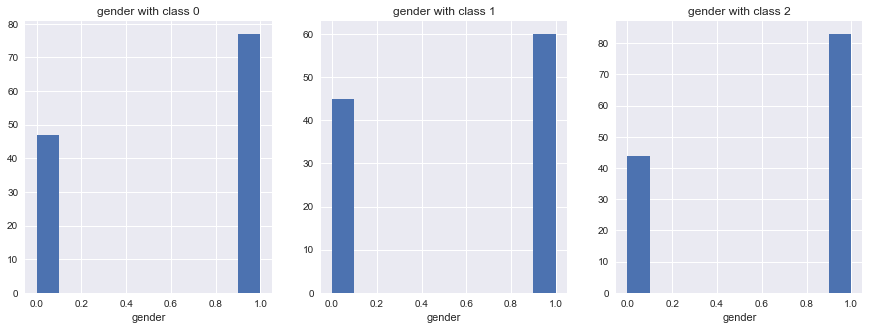

In [20]:
#gender
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#
#ax[0].scatter(data_fillNA_delay[['SCHEDULED_TIME']], data_fillNA_delay[['ARRIVAL_DELAY']], alpha=1.0)
ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTGENDER_cat'])
#ax.axhline(y=mean_pert, color='blue', label='zero error')

ax[0].set_xlabel('gender')
#ax[0].set_ylabel('Delay or not')
ax[0].set_title('gender with class 0')
                 
#ax[1].scatter(data_fillNA_delay[['ELAPSED_TIME']], data_fillNA_delay[['ARRIVAL_DELAY']], alpha=1.0)
#df.loc[df['DX_last'] == 0]

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTGENDER_cat'])
ax[1].set_xlabel('gender')
#ax[1].set_ylabel('Delay or not')
ax[1].set_title('gender with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTGENDER_cat'])
ax[2].set_xlabel('gender')
#ax[1].set_ylabel('Delay or not')
ax[2].set_title('gender with class 2')

plt.show()

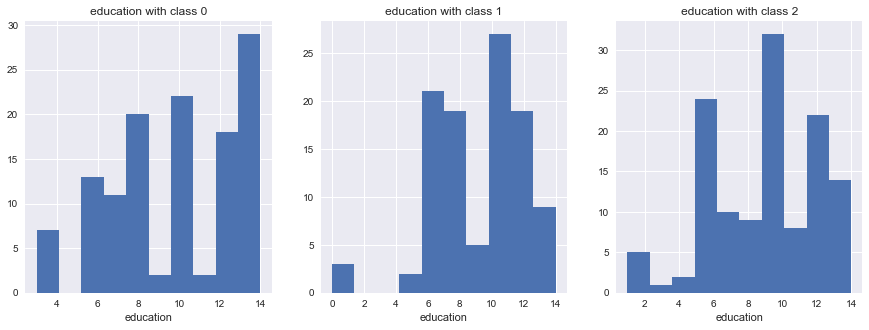

In [21]:
#education
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTEDUCAT_cat'])

ax[0].set_xlabel('education')

ax[0].set_title('education with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTEDUCAT_cat'])
ax[1].set_xlabel('education')

ax[1].set_title('education with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTEDUCAT_cat'])
ax[2].set_xlabel('education')

ax[2].set_title('education with class 2')

plt.show()

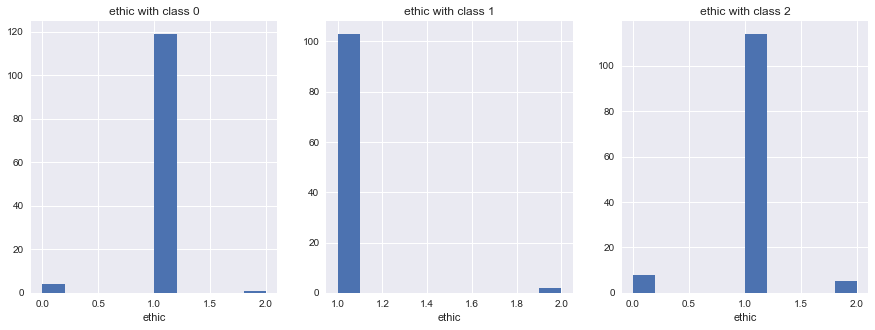

In [22]:
#ethic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTETHCAT_cat'])

ax[0].set_xlabel('ethic')

ax[0].set_title('ethic with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTETHCAT_cat'])
ax[1].set_xlabel('ethic')

ax[1].set_title('ethic with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTETHCAT_cat'])
ax[2].set_xlabel('ethic')

ax[2].set_title('ethic with class 2')

plt.show()

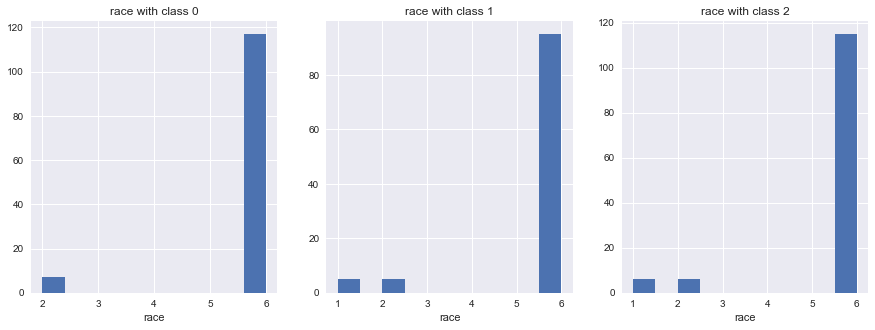

In [23]:
#race
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTRACCAT_cat'])

ax[0].set_xlabel('race')

ax[0].set_title('race with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTRACCAT_cat'])
ax[1].set_xlabel('race')

ax[1].set_title('race with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTRACCAT_cat'])
ax[2].set_xlabel('race')

ax[2].set_title('race with class 2')

plt.show()

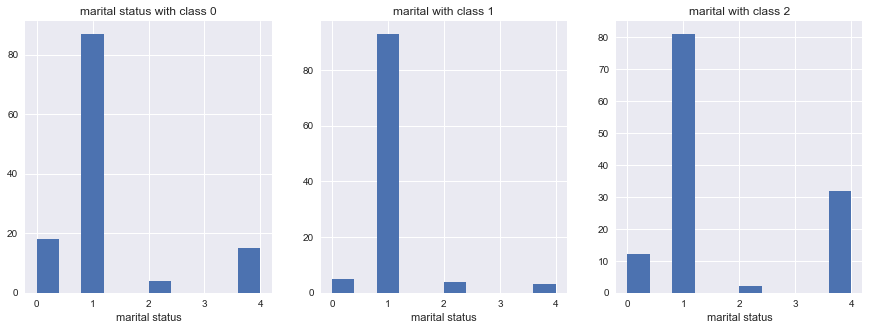

In [24]:
#marital status
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTMARRY_cat'])

ax[0].set_xlabel('marital status')

ax[0].set_title('marital status with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTMARRY_cat'])
ax[1].set_xlabel('marital status')

ax[1].set_title('marital with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTMARRY_cat'])
ax[2].set_xlabel('marital status')

ax[2].set_title('marital with class 2')

plt.show()

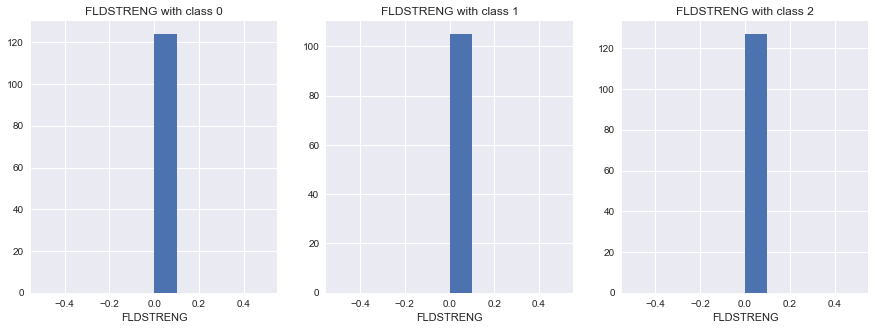

In [25]:
#marital status
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['FLDSTRENG_cat'])

ax[0].set_xlabel('FLDSTRENG')

ax[0].set_title('FLDSTRENG with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['FLDSTRENG_cat'])
ax[1].set_xlabel('FLDSTRENG')

ax[1].set_title('FLDSTRENG with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['FLDSTRENG_cat'])
ax[2].set_xlabel('FLDSTRENG')

ax[2].set_title('FLDSTRENG with class 2')

plt.show()

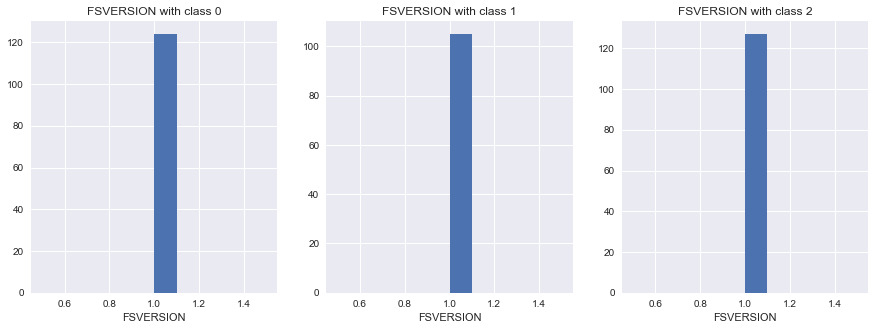

In [26]:
#FSVERSION_cat
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['FSVERSION_cat'])

ax[0].set_xlabel('FSVERSION')

ax[0].set_title('FSVERSION with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['FSVERSION_cat'])
ax[1].set_xlabel('FSVERSION')

ax[1].set_title('FSVERSION with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['FSVERSION_cat'])
ax[2].set_xlabel('FSVERSION')

ax[2].set_title('FSVERSION with class 2')

plt.show()

In [27]:
data_train=copy.copy(data_train_raw.drop('RID',axis=1))
data_train=data_train.drop('COLPROT',axis=1)

data_test=data_test_raw.drop('RID',axis=1)
data_test=data_test.drop('COLPROT',axis=1)

df_ADNI2=df_ADNI2.drop('RID',axis=1)
df_ADNI2=df_ADNI2.drop('COLPROT',axis=1)

df_ADNIGO=df_ADNIGO.drop('RID',axis=1)
df_ADNIGO=df_ADNIGO.drop('COLPROT',axis=1)



In [28]:
data_train.to_csv('data/data_train.csv')
data_test.to_csv('data/data_test.csv')

df_ADNI2.to_csv('data/df_ADNI2.csv')
df_ADNIGO.to_csv('data/df_ADNIGO.csv')


In [29]:
print(data_train.columns)
print(data_train_raw.columns)

Index(['DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last', 'DX_change', 'DX_last_cat', 'PTGENDER_cat_1',
       'PTEDUCAT_cat_1', 'PTEDUCAT_cat_2', 'PTEDUCAT_cat_3', 'PTEDUCAT_cat_4',
       'PTEDUCAT_cat_5', 'PTEDUCAT_cat_6', 'PTEDUCAT_cat_7', 'PTEDUCAT_cat_8',
       'PTEDUCAT_cat_9', 'PTEDUCAT_cat_10', 'PTEDUCAT_cat_11',
       'PTEDUCAT_cat_12', 'PTEDUCAT_cat_13', 'PTEDUCAT_cat_14',
       'PTETHCAT_cat_1', 'PTETHCAT_cat_2', 'PTRACCAT_cat_1', 'PTRACCAT_cat_2',
       'PTRACCAT_cat_3', 'PTRACCAT_cat_4', 'PTRACCAT_cat_5', 'PTRACCAT_cat_6',
       'PTMARRY_cat_1', 'PTMARRY_cat_2', 'PTMARRY_cat_3', 'PTMARRY_cat_4',
       'FLDSTRENG_cat_1', 'FSVERSION_cat_1'],
 

In [30]:
#drop those categorical predictors as they has been converted to dummy variable
print(categorical_columns_drop)
data_train=data_train.drop(categorical_columns_drop,axis=1)
data_test=data_test.drop(categorical_columns_drop,axis=1)
df_ADNI2=df_ADNI2.drop(categorical_columns_drop,axis=1)
df_ADNIGO=df_ADNIGO.drop(categorical_columns_drop,axis=1)

#print(df_fill_drop_clean_dummy[0:10])

['DX_bl', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'FLDSTRENG', 'FSVERSION', 'DX', 'DX_last', 'DX_change']


In [31]:
print(data_train.head())
print(data_train.columns)
print(data_train.describe())

         AGE     APOE4       FDG     CDRSB    ADAS11    ADAS13      MMSE  \
14  1.020509  0.874712 -0.643121  0.869085  1.236583  1.095293 -1.618155   
26 -0.270504 -0.738747  0.670531 -0.818520 -0.114927 -0.294192  0.654782   
59 -0.236530  0.874712 -0.710213  0.119038  0.294212  0.516051 -0.102864   
63  0.544873 -0.738747  0.370571 -0.818520 -0.934433 -0.873434  0.654782   
64  0.544873 -0.738747  0.959695 -0.818520 -0.892659 -1.017593  0.654782   

    RAVLT_immediate  RAVLT_learning  RAVLT_forgetting       ...         \
14        -0.874454       -1.064241         -0.036164       ...          
26         0.200072        0.014136          1.625028       ...          
59        -1.027958       -1.064241         -0.451462       ...          
63         0.890839        0.733054         -0.036164       ...          
64         0.353576        0.733054         -0.036164       ...          

    PTRACCAT_cat_3  PTRACCAT_cat_4  PTRACCAT_cat_5  PTRACCAT_cat_6  \
14               0          

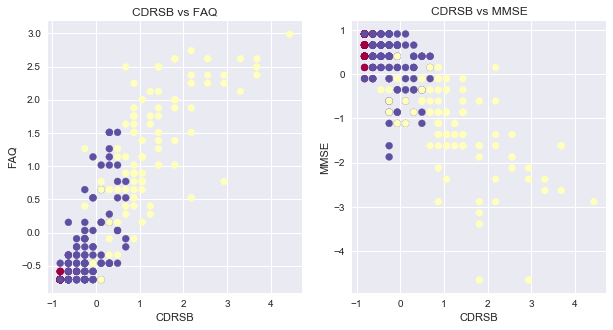

In [32]:
#scatter plot

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['CDRSB']],data_train[['FAQ']],alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('CDRSB')
ax[0].set_ylabel('FAQ')
ax[0].set_title('CDRSB vs FAQ')
                 
ax[1].scatter(data_train[['CDRSB']],data_train[['MMSE']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
ax[1].set_xlabel('CDRSB')
ax[1].set_ylabel('MMSE')
ax[1].set_title('CDRSB vs MMSE')
plt.show()

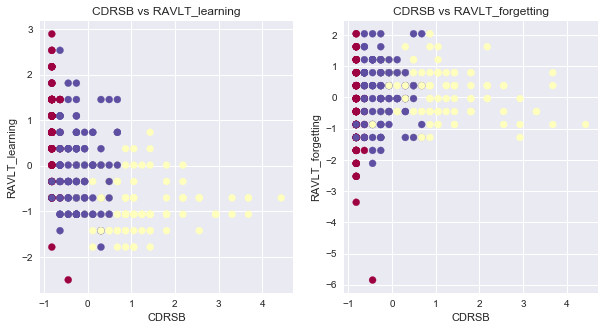

In [33]:
#scatter plot
#BIOMARKER data: CDRSB, FAQ, MMSE
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

colorMap = plt.get_cmap('Spectral')


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['CDRSB']],data_train[['RAVLT_learning']],alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('CDRSB')
ax[0].set_ylabel('RAVLT_learning')
ax[0].set_title('CDRSB vs RAVLT_learning')
                 
ax[1].scatter(data_train[['CDRSB']],data_train[['RAVLT_forgetting']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
ax[1].set_xlabel('CDRSB')
ax[1].set_ylabel('RAVLT_forgetting')
ax[1].set_title('CDRSB vs RAVLT_forgetting')
plt.show()

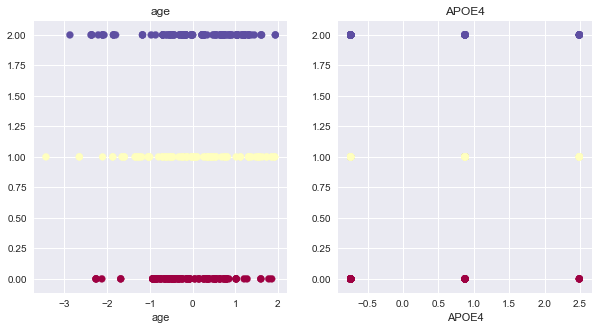

In [34]:
#scatter plot


colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['AGE']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('age')
ax[0].set_title('age')
                 
ax[1].scatter(data_train[['APOE4']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('APOE4')
ax[1].set_title('APOE4')
plt.show()

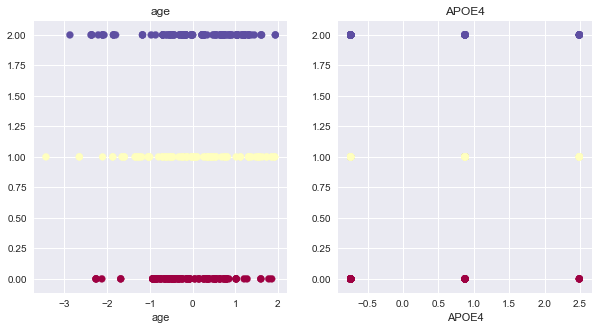

In [35]:
#scatter plot
#age
colorMap = plt.get_cmap('Spectral')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#

ax[0].scatter(data_train[['AGE']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('age')
ax[0].set_title('age')
                 
ax[1].scatter(data_train[['APOE4']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('APOE4')
ax[1].set_title('APOE4')
plt.show()

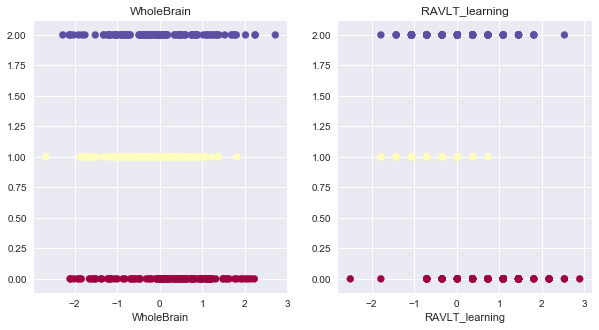

In [36]:
#scatter plot
#WholeBrain

colorMap = plt.get_cmap('Spectral')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['WholeBrain']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('WholeBrain')
ax[0].set_title('WholeBrain')

#RAVLT_learning
ax[1].scatter(data_train[['RAVLT_learning']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('RAVLT_learning')
ax[1].set_title('RAVLT_learning')
plt.show()

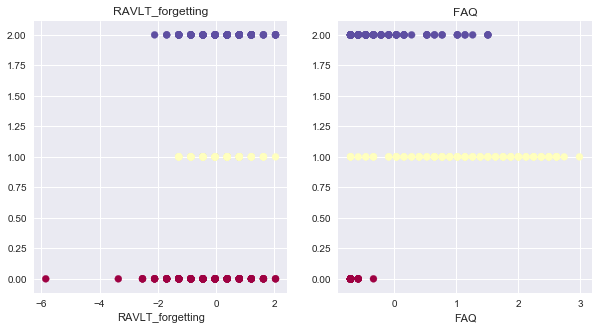

In [37]:
#scatter plot
#RAVLT_forgetting

colorMap = plt.get_cmap('Spectral')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['RAVLT_forgetting']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('RAVLT_forgetting')
ax[0].set_title('RAVLT_forgetting')

#FAQ
ax[1].scatter(data_train[['FAQ']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('FAQ')
ax[1].set_title('FAQ')
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


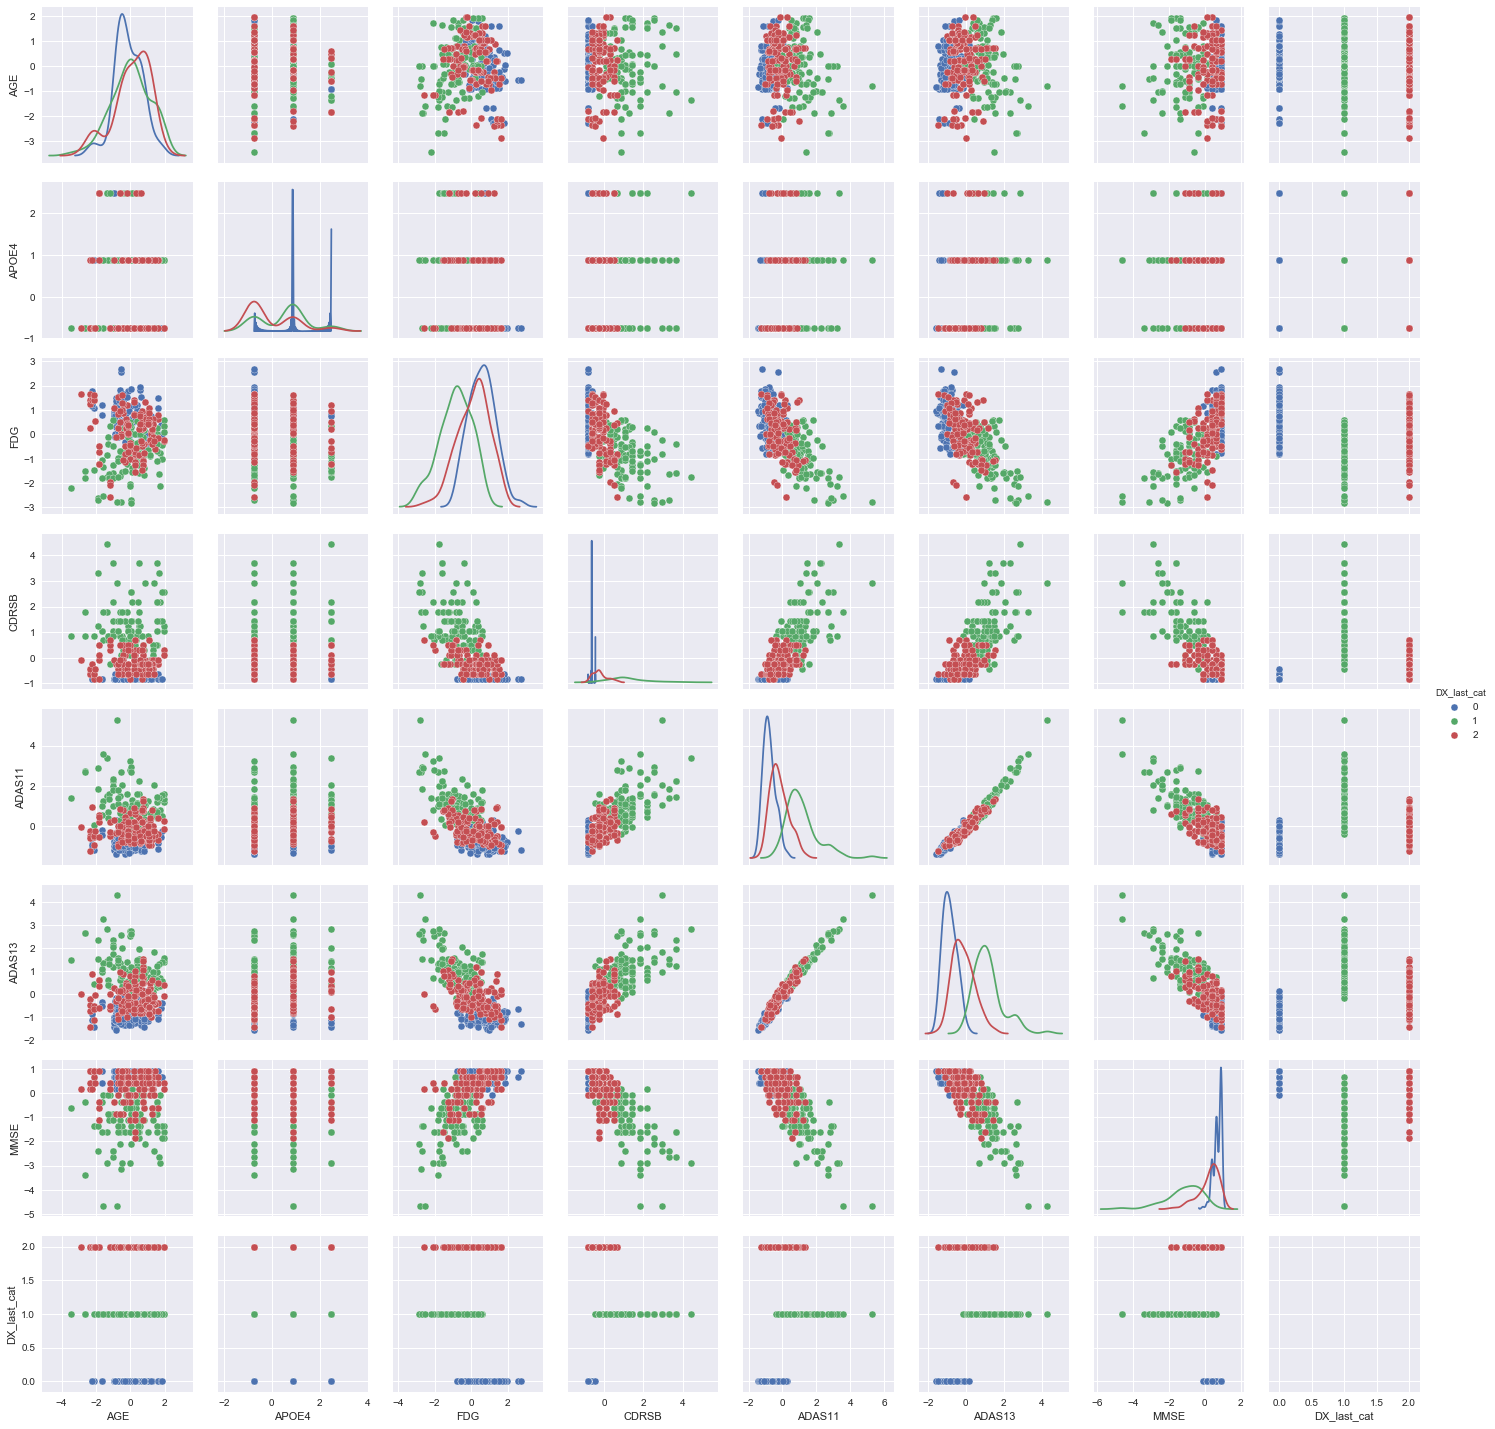

In [38]:
numerical_columns_plot_1= ['AGE', 'APOE4', 'FDG', 'CDRSB','ADAS11','ADAS13','MMSE','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_1, hue="DX_last_cat", size=2.5, diag_kind='kde');

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


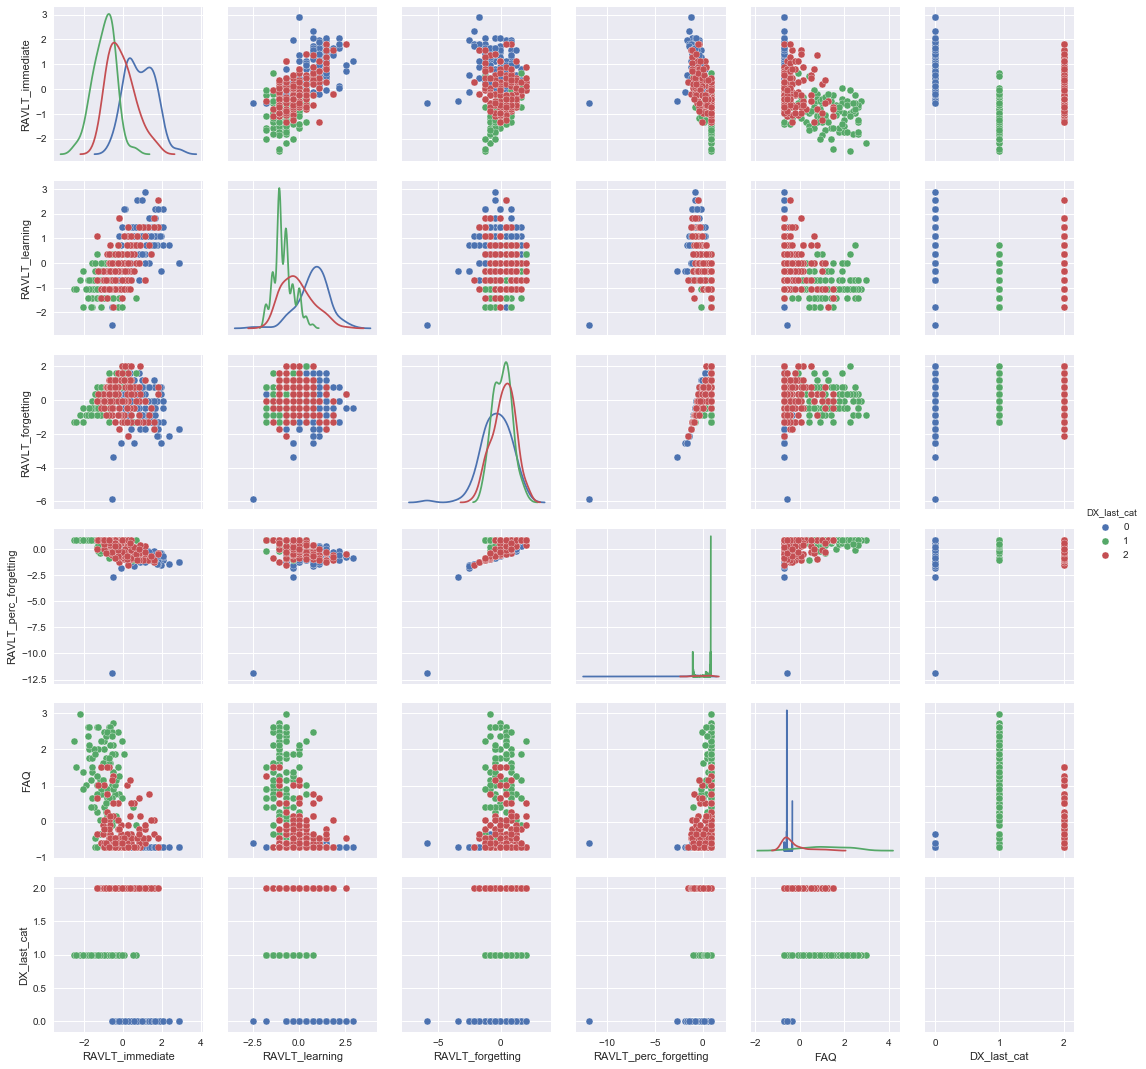

In [39]:
numerical_columns_plot_2= ['RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_2, hue="DX_last_cat", size=2.5, diag_kind='kde');

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


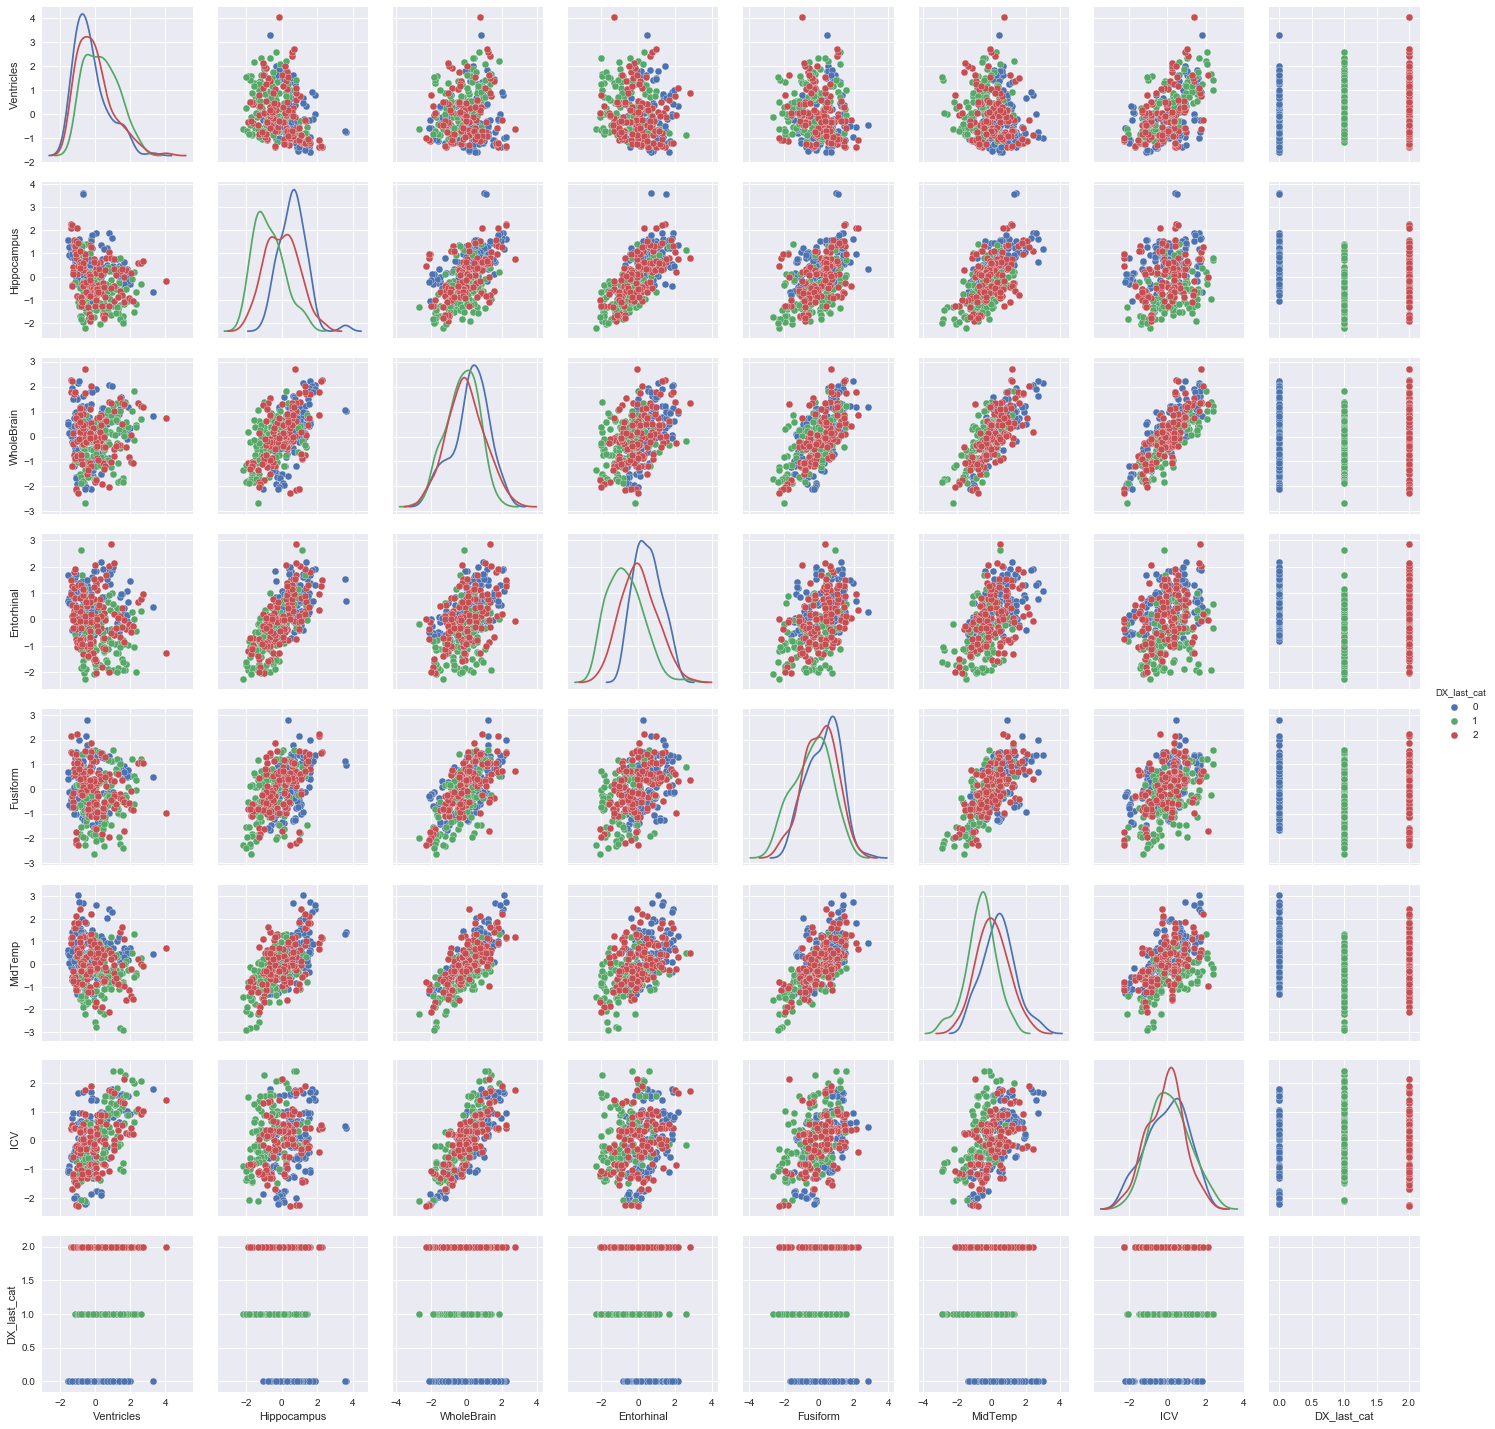

In [40]:
numerical_columns_plot_3= ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_3, hue="DX_last_cat", size=2.5, diag_kind='kde');

## based on above three pairwise plot, some predictors shows strong correlation between, some also shows clear regin between classes.

## 2.2 train model over ADNI1 and test on ADNI1 , ADNI2, and ADNIGO. baseline model is logistic regression model, tuned by cross validation. multinomial and OvR, LDA, QDA, KNN and decsion tree are tried. with base model and decision tree the best performance. But decision tree depth 2 and 3 are tried, which only have mariginal difference. depth 2 is picked. Decision tree has impression accuracy rate and give which predictors are most effective. Here only need 2 predictors.

In [41]:
#get X_train and y_train, X_test, y_test
X_train=copy.copy(data_train)
X_train=X_train.drop('DX_last_cat',axis=1)
#X_train=X_train.drop('RID',axis=1)
#X_train=X_train.drop('COLPROT',axis=1)
y_train=copy.copy(data_train['DX_last_cat'])


X_test=copy.copy(data_test)
X_test=X_test.drop('DX_last_cat',axis=1)
#X_test=X_test.drop('RID',axis=1)
#X_test=X_test.drop('COLPROT',axis=1)

y_test=copy.copy(data_test['DX_last_cat'])

X_test_ADNI2=copy.copy(df_ADNI2)
X_test_ADNI2=X_test_ADNI2.drop('DX_last_cat',axis=1)
#X_test_ADNI2=X_test_ADNI2.drop('RID',axis=1)
#X_test_ADNI2=X_test_ADNI2.drop('COLPROT',axis=1)
y_test_ADNI2=copy.copy(df_ADNI2['DX_last_cat'])

X_test_ADNIGO=copy.copy(df_ADNIGO)
X_test_ADNIGO=X_test_ADNIGO.drop('DX_last_cat',axis=1)
#X_test_ADNIGO=X_test_ADNIGO.drop('RID',axis=1)
#X_test_ADNIGO=X_test_ADNIGO.drop('COLPROT',axis=1)

y_test_ADNIGO=copy.copy(df_ADNIGO['DX_last_cat'])

#getting ADNI2 ANDIGO as test dataset


In [42]:
X_train.to_csv('data/X_train_DX_change.csv')
X_test.to_csv('data/X_test_DX_change.csv')

y_train.to_csv('data/y_train_DX_change.csv')
y_test.to_csv('data/y_test_DX_change.csv')


X_test_ADNI2.to_csv('data/X_test_ADNI2_DX_change.csv')
X_test_ADNIGO.to_csv('data/X_test_ADNIGO_DX_change.csv')

y_test_ADNI2.to_csv('data/y_test_ADNI2_DX_change.csv')
y_test_ADNIGO.to_csv('data/y_test_ADNIGO_DX_change.csv')

In [43]:
print(X_train.shape,X_test_ADNI2.shape)

(356, 48) (543, 48)


In [44]:
#run a logistic regression model with CV

logregcv = LogisticRegressionCV(random_state = 123) # By default LBGFS induces L2 norm.
result_log=logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
y_hat_test_ADNI2 = logregcv.predict(X_test_ADNI2)
y_hat_test_ADNIGO = logregcv.predict(X_test_ADNIGO)

print(pd.DataFrame(result_log.coef_ ))

print("logistic regression model:")
print("Train accuracy: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy: ", accuracy_score(y_test, y_hat_test))
print("Test accuracy ADNI2: ", accuracy_score(y_test_ADNI2, y_hat_test_ADNI2))
print("Test accuracy ADNIGO: ", accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO))

         0         1         2          3         4         5         6   \
0  0.440722 -2.686540 -3.846313 -27.259694  2.404494 -2.527896  6.350080   
1  0.647505  0.528305 -0.079245   3.307281  0.394206  1.713922 -0.492385   
2  0.001293 -0.000311  0.001535  -0.002616 -0.002170 -0.001575  0.002897   

         7         8         9     ...      38   39   40        41        42  \
0  4.550139 -0.594640  0.363712    ...     0.0  0.0  0.0  2.653383 -0.317098   
1 -0.733455 -0.228853  0.081583    ...     0.0  0.0  0.0 -0.260452  0.796474   
2 -0.001058 -0.001091  0.002878    ...     0.0  0.0  0.0 -0.000163 -0.001198   

         43   44        45   46        47  
0  1.856793  0.0 -2.060389  0.0 -0.989818  
1  1.141145  0.0 -0.997042  0.0 -0.000368  
2 -0.000156  0.0  0.001407  0.0  0.000002  

[3 rows x 48 columns]
logistic regression model:
Train accuracy:  0.960674157303
Test accuracy:  0.898123324397
Test accuracy ADNI2:  0.830570902394
Test accuracy ADNIGO:  0.828828828829


In [45]:
coef_list=pd.DataFrame(result_log.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])

class 0 top 3 predictors:
          c0         c1           c2              var
3  -27.2597    3.30728  -0.00261611            CDRSB
11 -11.7302  0.0679561  -0.00361895              FAQ
30 -8.65535  -0.638732  0.000335544  PTEDUCAT_cat_11
class 1 top 3 predictors:
           c0       c1           c2             var
3   -27.2597  3.30728  -0.00261611           CDRSB
5    -2.5279  1.71392  -0.00157477          ADAS13
34 -0.388585   1.7126 -0.000583243  PTETHCAT_cat_1
class 2 top 3 predictors::
           c0         c1          c2               var
11  -11.7302  0.0679561 -0.00361895               FAQ
6    6.35008  -0.492385  0.00289657              MMSE
9   0.363712  0.0815829   0.0028781  RAVLT_forgetting


In [46]:
print("logistic regression model:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

logistic regression model:
Confusion Matrix Train:
[[124   0   1]
 [  0 101   9]
 [  0   4 117]]
Confusion Matrix Test:
[[122   0   7]
 [  0  98  13]
 [ 10   8 115]]
Confusion Matrix Test ADNI2:
[[219   0  47]
 [  0  69   8]
 [ 29   8 163]]
Confusion Matrix Test ADNIGO:
[[27  0 13]
 [ 0  0  5]
 [ 1  0 65]]


In [47]:
#multinomial logistic regression with CV
logit_multi=LogisticRegressionCV(penalty='l2',multi_class='multinomial')
result_logit_multi=logit_multi.fit(X_train,y_train)

y_train_logit_multi_pred=result_logit_multi.predict(X_train)
y_test_logit_multi_pred=result_logit_multi.predict(X_test)

ytrain_pred = np.ravel(y_train_logit_multi_pred)
ytest_pred = np.ravel(y_test_logit_multi_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

acc_rate_logit_mulit_train=accuracy_score(ytrain,ytrain_pred)
acc_rate_logit_mulit_test=accuracy_score(ytest,ytest_pred)


y_hat_test_ADNI2 = result_logit_multi.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_logit_multi.predict(X_test_ADNIGO)

acc_rate_logit_mulit_test_ADNI2=accuracy_score(y_test_ADNI2, y_hat_test_ADNI2)
acc_rate_logit_mulit_test_ADNIGO=accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO)

print(pd.DataFrame(result_logit_multi.coef_ ))
print("multinomial logistic regression: ")
print("Train accuracy: ",acc_rate_logit_mulit_train)
print("Test accuracy: ",acc_rate_logit_mulit_test)
print("Test accuracy ADNI2: ",acc_rate_logit_mulit_test_ADNI2)
print("Test accuracy ADNIGO: ",acc_rate_logit_mulit_test_ADNIGO)


         0         1         2         3         4         5         6   \
0 -0.050161 -0.780480 -0.471546 -5.680995  0.042423 -1.196304  1.469460   
1  0.355944  0.689085  0.104217  4.228080  0.219654  1.489189 -1.033485   
2 -0.305783  0.091395  0.367328  1.452915 -0.262077 -0.292886 -0.435974   

         7         8         9     ...      38   39   40        41        42  \
0  1.024812  0.169936  0.126927    ...     0.0  0.0  0.0  0.811126 -0.290648   
1 -1.017701 -0.415219  0.316718    ...     0.0  0.0  0.0 -0.467687  0.598212   
2 -0.007111  0.245284 -0.443645    ...     0.0  0.0  0.0 -0.343440 -0.307564   

         43   44        45   46        47  
0  0.172123  0.0 -0.386113  0.0 -0.001832  
1  0.782072  0.0 -0.513512  0.0  0.008897  
2 -0.954196  0.0  0.899625  0.0 -0.007065  

[3 rows x 48 columns]
multinomial logistic regression: 
Train accuracy:  0.955056179775
Test accuracy:  0.906166219839
Test accuracy ADNI2:  0.830570902394
Test accuracy ADNIGO:  0.810810810811


In [48]:
coef_list=pd.DataFrame(result_logit_multi.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])


class 0 top 3 predictors:
          c0       c1        c2    var
3    -5.681  4.22808   1.45291  CDRSB
11 -2.52636  1.29392   1.23244    FAQ
6   1.46946 -1.03349 -0.435974   MMSE
class 1 top 3 predictors:
           c0       c1        c2             var
3     -5.681  4.22808   1.45291           CDRSB
5    -1.1963  1.48919 -0.292886          ADAS13
34 -0.498681  1.48152 -0.982837  PTETHCAT_cat_1
class 2 top 3 predictors::
          c0        c1       c2              var
3    -5.681   4.22808  1.45291            CDRSB
30 -1.11817 -0.231686  1.34986  PTEDUCAT_cat_11
11 -2.52636   1.29392  1.23244              FAQ


In [49]:
print("multinomial logistic regression: ")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

multinomial logistic regression: 
Confusion Matrix Train:
[[124   0   1]
 [  0 101   9]
 [  0   4 117]]
Confusion Matrix Test:
[[122   0   7]
 [  0  98  13]
 [ 10   8 115]]
Confusion Matrix Test ADNI2:
[[222   0  53]
 [  0  67   3]
 [ 26  10 162]]
Confusion Matrix Test ADNIGO:
[[27  0 16]
 [ 0  0  4]
 [ 1  0 63]]


In [50]:
#one-vs-rest (OvR) logistic regression with CV
logit_OvR=LogisticRegressionCV(penalty='l2',multi_class='ovr')
result_logit_OvR=logit_OvR.fit(X_train,y_train)

y_train_logit_OvR_pred=result_logit_OvR.predict(X_train)
y_test_logit_OvR_pred=result_logit_OvR.predict(X_test)

ytrain_pred = np.ravel(y_train_logit_OvR_pred)
ytest_pred = np.ravel(y_test_logit_OvR_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

acc_rate_logit_OvR_train=accuracy_score(ytrain,ytrain_pred)
acc_rate_logit_OvR_test=accuracy_score(ytest,ytest_pred)


y_hat_test_ADNI2 = result_logit_OvR.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_logit_OvR.predict(X_test_ADNIGO)

acc_rate_logit_OvR_test_ADNI2=accuracy_score(y_test_ADNI2, y_hat_test_ADNI2)
acc_rate_logit_OvR_test_ADNIGO=accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO)

print(pd.DataFrame(result_logit_OvR.coef_ ))

print("OvR logistic regression: ")
print("Train accuracy",acc_rate_logit_OvR_train)
print("Test accuracy",acc_rate_logit_OvR_test)

print("Train accuracy ADNI2",acc_rate_logit_OvR_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_logit_OvR_test_ADNIGO)


         0         1         2          3         4         5         6   \
0  0.440722 -2.686540 -3.846313 -27.259694  2.404494 -2.527896  6.350080   
1  0.647505  0.528305 -0.079245   3.307281  0.394206  1.713922 -0.492385   
2  0.001293 -0.000311  0.001535  -0.002616 -0.002170 -0.001575  0.002897   

         7         8         9     ...      38   39   40        41        42  \
0  4.550139 -0.594640  0.363712    ...     0.0  0.0  0.0  2.653383 -0.317098   
1 -0.733455 -0.228853  0.081583    ...     0.0  0.0  0.0 -0.260452  0.796474   
2 -0.001058 -0.001091  0.002878    ...     0.0  0.0  0.0 -0.000163 -0.001198   

         43   44        45   46        47  
0  1.856793  0.0 -2.060389  0.0 -0.989818  
1  1.141145  0.0 -0.997042  0.0 -0.000368  
2 -0.000156  0.0  0.001407  0.0  0.000002  

[3 rows x 48 columns]
OvR logistic regression: 
Train accuracy 0.960674157303
Test accuracy 0.898123324397
Train accuracy ADNI2 0.830570902394
Test accuracy ADNIGO 0.828828828829


In [51]:
#print(pd.DataFrame(result_logit_OvR.coef_ ))
coef_list=pd.DataFrame(result_logit_OvR.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])


class 0 top 3 predictors:
          c0         c1           c2              var
3  -27.2597    3.30728  -0.00261611            CDRSB
11 -11.7302  0.0679561  -0.00361895              FAQ
30 -8.65535  -0.638732  0.000335544  PTEDUCAT_cat_11
class 1 top 3 predictors:
           c0       c1           c2             var
3   -27.2597  3.30728  -0.00261611           CDRSB
5    -2.5279  1.71392  -0.00157477          ADAS13
34 -0.388585   1.7126 -0.000583243  PTETHCAT_cat_1
class 2 top 3 predictors::
           c0         c1          c2               var
11  -11.7302  0.0679561 -0.00361895               FAQ
6    6.35008  -0.492385  0.00289657              MMSE
9   0.363712  0.0815829   0.0028781  RAVLT_forgetting


In [52]:
print("OvR logistic regression:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

OvR logistic regression:
Confusion Matrix Train:
[[124   0   1]
 [  0 101   9]
 [  0   4 117]]
Confusion Matrix Test:
[[122   0   7]
 [  0  98  13]
 [ 10   8 115]]
Confusion Matrix Test ADNI2:
[[219   0  47]
 [  0  69   8]
 [ 29   8 163]]
Confusion Matrix Test ADNIGO:
[[27  0 13]
 [ 0  0  5]
 [ 1  0 65]]


In [53]:
#LDA
lda = da.LinearDiscriminantAnalysis()
result_lda=lda.fit(X_train,y_train)

y_train_lda_pred=result_lda.predict(X_train)
y_test_lda_pred=result_lda.predict(X_test)

ytrain_pred = np.ravel(y_train_lda_pred)
ytest_pred = np.ravel(y_test_lda_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)


print(pd.DataFrame(result_lda.coef_ ))

#acc_rate_lda_train=accuarcy_rate(ytrain,ytrain_pred)
acc_rate_lda_train=result_lda.score(X_train,y_train)
acc_rate_lda_test=result_lda.score(X_test,y_test)
#acc_rate_lda_test=accuarcy_rate(ytest,ytest_pred)

y_hat_test_ADNI2 = result_lda.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_lda.predict(X_test_ADNIGO)

acc_rate_lda_test_ADNI2=result_lda.score(X_test_ADNI2, y_test_ADNI2)
acc_rate_lda_test_ADNIGO=result_lda.score(X_test_ADNIGO, y_test_ADNIGO)


print("LDA: ")
print("Train accuracy",acc_rate_lda_train)
print("Test accuracy",acc_rate_lda_test)

print("Train accuracy ADNI2",acc_rate_lda_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_lda_test_ADNIGO)


         0         1         2         3         4         5         6   \
0 -0.236424 -0.460226 -0.080404 -2.360150  4.175403 -5.517894 -0.358767   
1  0.409579  0.541840  0.044250  2.765087 -5.033359  6.734698 -0.022516   
2 -0.107789  0.001377  0.041920  0.018303  0.084667 -0.180507  0.368908   

         7         8         9  ...             38            39  \
0  1.178060  0.312862  0.256579 ...  -1.683174e-16  9.302364e-17   
1 -1.037234 -0.153876 -0.457103 ...   2.349186e-16 -1.295507e-16   
2 -0.292676 -0.178252  0.127402 ...  -2.988265e-17  1.628258e-17   

             40        41        42        43   44        45   46   47  
0  1.910062e-16  0.801331 -0.573735 -0.182355  0.0 -0.932637  0.0  0.0  
1 -2.265303e-16 -0.772216  1.092873  1.657287  0.0 -0.638972  0.0  0.0  
2  7.946493e-19 -0.143956 -0.343374 -1.192150  0.0  1.438890  0.0  0.0  

[3 rows x 48 columns]
LDA: 
Train accuracy 0.890449438202
Test accuracy 0.825737265416
Train accuracy ADNI2 0.72744014733
Test accura

C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [54]:
#print(pd.DataFrame(result_lda.coef_ ))
coef_list=pd.DataFrame(result_lda.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])

class 0 top 3 predictors:
          c0       c1         c2             var
5  -5.51789   6.7347  -0.180507          ADAS13
4    4.1754 -5.03336  0.0846668          ADAS11
36 -4.02693  3.11374    1.35746  PTRACCAT_cat_1
class 1 top 3 predictors:
           c0       c1         c2             var
5   -5.51789   6.7347  -0.180507          ADAS13
4     4.1754 -5.03336  0.0846668          ADAS11
20 -0.236903 -4.42677    3.89124  PTEDUCAT_cat_1
class 2 top 3 predictors::
           c0       c1       c2              var
20 -0.236903 -4.42677  3.89124   PTEDUCAT_cat_1
21 -0.336684 -3.02088   2.8263   PTEDUCAT_cat_2
30  -1.82714 -1.24123  2.81019  PTEDUCAT_cat_11


In [55]:
print("LDA:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

LDA:
Confusion Matrix Train:
[[124   0   1]
 [  0 101   9]
 [  0   4 117]]
Confusion Matrix Test:
[[122   0   7]
 [  0  98  13]
 [ 10   8 115]]
Confusion Matrix Test ADNI2:
[[216   1 100]
 [  1  64   3]
 [ 31  12 115]]
Confusion Matrix Test ADNIGO:
[[25  0 39]
 [ 0  0  2]
 [ 3  0 42]]


In [61]:
#QDA
qda = da.QuadraticDiscriminantAnalysis()
result_qda=qda.fit(X_train,y_train)

y_train_qda_pred=result_qda.predict(X_train)
y_test_qda_pred=result_qda.predict(X_test)

ytrain_pred = np.ravel(y_train_qda_pred)
ytest_pred = np.ravel(y_test_qda_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

y_test_qda_pred_ADNI2=result_qda.predict(X_test_ADNI2)
y_test_qda_pred_ADNIGO=result_qda.predict(X_test_ADNIGO)

#acc_rate_qda_train=accuarcy_rate(ytrain,ytrain_pred)
#acc_rate_qda_test=accuarcy_rate(ytest,ytest_pred)
acc_rate_qda_train=result_qda.score(X_train,y_train)
acc_rate_qda_test=result_qda.score(X_test,y_test)

acc_rate_qda_test_ADNI2=result_qda.score(X_test_ADNI2, y_test_ADNI2)
acc_rate_qda_test_ADNIGO=result_qda.score(X_test_ADNIGO, y_test_ADNIGO)



#print(pd.DataFrame(result_qda.coef_ ))

print("QDA: ")
print("Train accuracy",acc_rate_qda_train)
print("Test accuracy",acc_rate_qda_test)

print("Train accuracy ADNI2",acc_rate_qda_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_qda_test_ADNIGO)


QDA: 
Train accuracy 0.792134831461
Test accuracy 0.697050938338
Train accuracy ADNI2 0.421731123389
Test accuracy ADNIGO 0.837837837838


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [62]:
print("QDA:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_qda_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_qda_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_qda_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_qda_pred_ADNIGO, y_test_ADNIGO))

QDA:
Confusion Matrix Train:
[[124   0  30]
 [  0 103  42]
 [  0   2  55]]
Confusion Matrix Test:
[[128   0  38]
 [  3  91  56]
 [  1  15  41]]
Confusion Matrix Test ADNI2:
[[ 19   0   4]
 [  7   5   9]
 [222  72 205]]
Confusion Matrix Test ADNIGO:
[[23  0  6]
 [ 0  0  7]
 [ 5  0 70]]


In [63]:
#KNN
result_knn_list_cv=[]

for k in range (1,60):
#for k in range (1,60):
    item=[]
    #knn_temp = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    result_knn_temp=knn_temp.fit(X_train, np.ravel(y_train))

    #dt_cv = DecisionTreeClassifier(criterion='gini')
    #dt_cv.fit(X_train,y_train)
    #x=X_train
    scores=cross_val_score(result_knn_temp, X_train, np.ravel(y_train), cv=10)
    item.append(k)
    mean_temp=np.mean(scores)
    item.append(mean_temp)
    result_knn_list_cv.append(item)

result_knn_list_cv=pd.DataFrame(result_knn_list_cv)
result_knn_list_cv.columns=('knn-k','score')
print(result_knn_list_cv.sort_values('score',ascending=False)[0:10])   


    knn-k     score
27     28  0.772365
40     41  0.772295
41     42  0.772132
39     40  0.772132
38     39  0.769667
30     31  0.769592
19     20  0.767844
36     37  0.766965
37     38  0.766965
32     33  0.766726


In [64]:
  
knn = KNeighborsClassifier(n_neighbors=28)
result_knn=knn_temp.fit(X_train, np.ravel(y_train))

acc_rate_knn_train=result_knn.score(X_train,y_train)
acc_rate_knn_test=result_knn.score(X_test,y_test)

acc_rate_knn_test_ADNI2=result_knn.score(X_test_ADNI2,y_test_ADNI2)
acc_rate_knn_test_ADNIGO=result_knn.score(X_test_ADNIGO,y_test_ADNIGO)

print("KNN: ")
print("Train accuracy",acc_rate_knn_train)
print("Test accuracy",acc_rate_knn_test)

print("Train accuracy ADNI2",acc_rate_knn_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_knn_test_ADNIGO)

KNN: 
Train accuracy 0.766853932584
Test accuracy 0.782841823056
Train accuracy ADNI2 0.686924493554
Test accuracy ADNIGO 0.459459459459


In [65]:
y_train_knn_pred=result_knn.predict(X_train)
y_test_knn_pred=result_knn.predict(X_test)
y_test_knn_pred_ADNI2=result_knn.predict(X_test_ADNI2)
y_test_knn_pred_ADNIGO=result_knn.predict(X_test_ADNIGO)

print("KNN:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_knn_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_knn_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_knn_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_knn_pred_ADNIGO, y_test_ADNIGO))


KNN:
Confusion Matrix Train:
[[113   0  42]
 [  0  92  17]
 [ 11  13  68]]
Confusion Matrix Test:
[[121   0  51]
 [  0  96   9]
 [ 11  10  75]]
Confusion Matrix Test ADNI2:
[[234   2 143]
 [  0  66   2]
 [ 14   9  73]]
Confusion Matrix Test ADNIGO:
[[26  0 55]
 [ 0  0  3]
 [ 2  0 25]]


In [66]:
#decision tree
depths = [i for i in range(2, 40)]
train_scores = []
test_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train,y_train)
    train_scores.append(clf.score(X_train,y_train))
    test_scores.append(clf.score(X_test,y_test))

print(pd.DataFrame(train_scores),pd.DataFrame(test_scores))

           0
0   0.879213
1   0.901685
2   0.929775
3   0.957865
4   0.977528
5   0.988764
6   0.991573
7   0.994382
8   0.994382
9   1.000000
10  1.000000
11  1.000000
12  1.000000
13  1.000000
14  1.000000
15  1.000000
16  1.000000
17  1.000000
18  1.000000
19  1.000000
20  1.000000
21  1.000000
22  1.000000
23  1.000000
24  1.000000
25  1.000000
26  1.000000
27  1.000000
28  1.000000
29  1.000000
30  1.000000
31  1.000000
32  1.000000
33  1.000000
34  1.000000
35  1.000000
36  1.000000
37  1.000000            0
0   0.887399
1   0.890080
2   0.857909
3   0.884718
4   0.887399
5   0.871314
6   0.876676
7   0.868633
8   0.882038
9   0.876676
10  0.868633
11  0.876676
12  0.857909
13  0.857909
14  0.876676
15  0.865952
16  0.852547
17  0.844504
18  0.852547
19  0.882038
20  0.868633
21  0.887399
22  0.873995
23  0.844504
24  0.884718
25  0.871314
26  0.855228
27  0.847185
28  0.868633
29  0.865952
30  0.863271
31  0.876676
32  0.855228
33  0.873995
34  0.844504
35  0.879357
36  0.852547

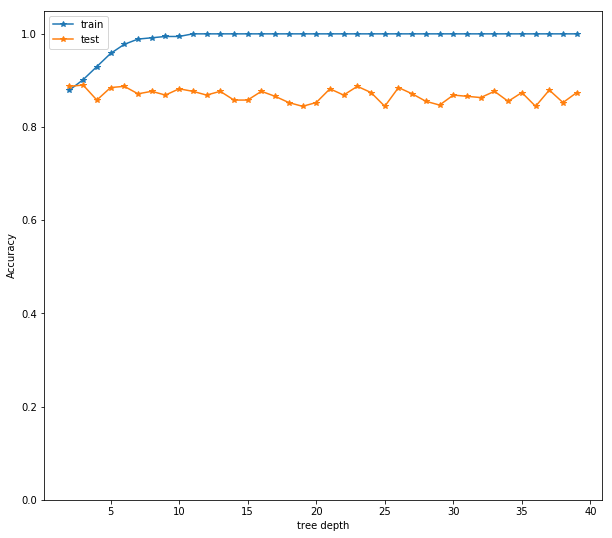

In [67]:
plt.figure(figsize=(10, 9))
plt.plot(depths, train_scores, '*-', label='train')
plt.plot(depths, test_scores, '*-', label='test')
plt.legend(loc='best')
plt.xlabel('tree depth')
plt.ylabel('Accuracy')
plt.ylim((0, 1.05))
plt.show()



In [76]:
clf = DecisionTreeClassifier(max_depth=2)
result_df=clf.fit(X_train, y_train)
print("Decision Tree:")
print ('Train score:', clf.score(X_train, y_train))
print ('Test score:', clf.score(X_test, y_test))
print ('Test score ADNI2:', clf.score(X_test_ADNI2, y_test_ADNI2))
print ('Test score ADNIGO:', clf.score(X_test_ADNIGO, y_test_ADNIGO))

Decision Tree:
Train score: 0.879213483146
Test score: 0.887399463807
Test score ADNI2: 0.918968692449
Test score ADNIGO: 0.936936936937


In [69]:
y_train_df_pred=result_df.predict(X_train)
y_test_df_pred=result_df.predict(X_test)
y_test_df_pred_ADNI2=result_df.predict(X_test_ADNI2)
y_test_df_pred_ADNIGO=result_df.predict(X_test_ADNIGO)

print("Decision Tree:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_df_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_df_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_df_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_df_pred_ADNIGO, y_test_ADNIGO))


Decision Tree:
Confusion Matrix Train:
[[114   0   3]
 [  0 100  17]
 [ 10   5 107]]
Confusion Matrix Test:
[[119   0   4]
 [  0  97  17]
 [ 13   9 114]]
Confusion Matrix Test ADNI2:
[[220   0   4]
 [  0  68   4]
 [ 28   9 210]]
Confusion Matrix Test ADNIGO:
[[25  0  1]
 [ 0  0  3]
 [ 3  0 79]]


In [78]:
dotfile = open("data/dtree2_DX_change_depth2.txt", 'w')
tree.export_graphviz(result_df, out_file = dotfile, feature_names = X_train.columns)
dotfile.close()

In [79]:
clf = DecisionTreeClassifier(max_depth=3)
result_df=clf.fit(X_train, y_train)
print("Decision Tree:")
print ('Train score:', clf.score(X_train, y_train))
print ('Test score:', clf.score(X_test, y_test))
print ('Test score ADNI2:', clf.score(X_test_ADNI2, y_test_ADNI2))
print ('Test score ADNIGO:', clf.score(X_test_ADNIGO, y_test_ADNIGO))

Decision Tree:
Train score: 0.901685393258
Test score: 0.88471849866
Test score ADNI2: 0.917127071823
Test score ADNIGO: 0.936936936937


In [80]:
y_train_df_pred=result_df.predict(X_train)
y_test_df_pred=result_df.predict(X_test)
y_test_df_pred_ADNI2=result_df.predict(X_test_ADNI2)
y_test_df_pred_ADNIGO=result_df.predict(X_test_ADNIGO)

print("Decision Tree:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_df_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_df_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_df_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_df_pred_ADNIGO, y_test_ADNIGO))

Decision Tree:
Confusion Matrix Train:
[[114   0   3]
 [  0 100  17]
 [ 10   5 107]]
Confusion Matrix Test:
[[119   0   4]
 [  0  97  17]
 [ 13   9 114]]
Confusion Matrix Test ADNI2:
[[220   0   4]
 [  0  68   4]
 [ 28   9 210]]
Confusion Matrix Test ADNIGO:
[[25  0  1]
 [ 0  0  3]
 [ 3  0 79]]
